In [28]:
#Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [29]:
# Function to split dataset
def split(df, label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [30]:
# List of classifiers and their models
classifiers = ['LinearSVM', 'RadialSVM', 'Logistic', 'RandomForest', 'AdaBoost', 'DecisionTree', 'KNeighbors', 'GradientBoosting']
models = [
    svm.SVC(kernel='linear'),
    svm.SVC(kernel='rbf'),
    LogisticRegression(max_iter=1000),
    RandomForestClassifier(n_estimators=200, random_state=0),
    AdaBoostClassifier(random_state=0),
    DecisionTreeClassifier(random_state=0),
    KNeighborsClassifier(),
    GradientBoostingClassifier(random_state=0)
]

In [31]:
# Function to compute accuracy scores for classifiers
def acc_score(df, label):
    Score = pd.DataFrame({"Classifier": classifiers})
    acc = []
    X_train, X_test, Y_train, Y_test = split(df, label)
    for model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test, predictions))
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False, inplace=True)
    Score.reset_index(drop=True, inplace=True)
    return Score


In [32]:
# Function to plot results
def plot(score, x, y, c="b"):
    gen = list(range(1, len(score) + 1))
    plt.figure(figsize=(6, 4))
    ax = sns.pointplot(x=gen, y=score, color=c)
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x, y))

In [33]:
# Initialize a random population
def initilization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype=np.bool)     
        chromosome[:int(0.3 * n_feat)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [34]:
# Compute fitness scores
def fitness_score(population, X_train, Y_train, X_test, Y_test):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:, chromosome], Y_train)         
        predictions = logmodel.predict(X_test.iloc[:, chromosome])
        scores.append(accuracy_score(Y_test, predictions))
    scores, population = np.array(scores), np.array(population) 
    inds = np.argsort(scores)                                    
    return list(scores[inds][::-1]), list(population[inds][:][::-1]) 


In [35]:
# Select the best parents
def selection(pop_after_fit, n_parents):
    return pop_after_fit[:n_parents]

In [36]:
# Perform crossover
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel.copy()
    for i in range(0, len(pop_after_sel), 2):
        if i + 1 < len(pop_after_sel):
            child_1, child_2 = pop_after_sel[i], pop_after_sel[i + 1]
            crossover_point = randint(1, len(child_1) - 1)
            child_1[crossover_point:], child_2[crossover_point:] = child_2[crossover_point:], child_1[crossover_point:]
            pop_nextgen.extend([child_1, child_2])
    return pop_nextgen

In [37]:
# Perform mutation
def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for chromo in pop_after_cross:
        chromo = chromo.copy()
        for _ in range(mutation_range):
            pos = randint(0, n_feat - 1)
            chromo[pos] = not chromo[pos]
        pop_next_gen.append(chromo)
    return pop_next_gen

In [38]:

def generations(df, label, size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, Y_train, Y_test):
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(size, n_feat)
    best_overall_score = 0
    best_overall_chromo = None

    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen, X_train, Y_train, X_test, Y_test)

        if scores[0] > best_overall_score:
            best_overall_score = scores[0]
            best_overall_chromo = pop_after_fit[0]
        else:
            scores[0] = best_overall_score
            pop_after_fit[0] = best_overall_chromo

        print(f'Best score in generation {i + 1}: {scores[0]}')
        print(f'Best chromosome in generation {i + 1}: {pop_after_fit[0].astype(int)}')  # Print the best chromosome

        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)

        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])

    return best_chromo, best_score

# Data

In [39]:
# Function to plot the comparison of scores
def plot_comparison(score1, score2):
    # Create a DataFrame for plotting
    comparison_df = pd.DataFrame({
        'Classifier': score1['Classifier'],
        'Original': score1['Accuracy'],
        'Filtered': score2['Accuracy']
    })

    # Melt the DataFrame to long format for seaborn
    comparison_df = comparison_df.melt(id_vars='Classifier', var_name='Dataset', value_name='Accuracy')

    # Plot the comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Classifier', y='Accuracy', hue='Dataset', data=comparison_df)
    plt.title('Comparison of Classifier Accuracy on Original vs Filtered Dataset')
    plt.xticks(rotation=45)
    plt.ylim(0.9, 1.0)  # Set y-axis limit for better visualization
    plt.show()

In [40]:
# Load and preprocess the dataset
data_bc = pd.read_csv("data.csv")
label_bc = data_bc["diagnosis"].apply(lambda x: 1 if x == 'M' else 0)
data_bc.drop(["id", "diagnosis", "Unnamed: 32"], axis=1, inplace=True)

In [41]:
print("Breast Cancer dataset:\n", data_bc.shape[0], "Records\n", data_bc.shape[1], "Features")
display(data_bc.head())

Breast Cancer dataset:
 569 Records
 30 Features


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [42]:
# Evaluate classifiers on the original dataset
score1 = acc_score(data_bc, label_bc)
print("Original dataset scores:\n", score1)

Original dataset scores:
          Classifier  Accuracy
0      RandomForest  0.972028
1          Logistic  0.965035
2        KNeighbors  0.965035
3         LinearSVM  0.958042
4  GradientBoosting  0.958042
5         RadialSVM  0.951049
6          AdaBoost  0.951049
7      DecisionTree  0.930070


In [43]:
# Choose the best classifier and run GA for feature selection
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train, X_test, Y_train, Y_test = split(data_bc, label_bc)
chromo_df_bc, score_bc = generations(data_bc, label_bc, size=80, n_feat=data_bc.shape[1], n_parents=64, mutation_rate=0.20, n_gen=5,
                                     X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

Best score in generation 1: 0.993006993006993
Best chromosome in generation 1: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 1]
Best score in generation 2: 0.993006993006993
Best chromosome in generation 2: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0]
Best score in generation 3: 0.993006993006993
Best chromosome in generation 3: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 1 0 1 1]
Best score in generation 4: 0.993006993006993
Best chromosome in generation 4: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0]
Best score in generation 5: 0.993006993006993
Best chromosome in generation 5: [1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 0]


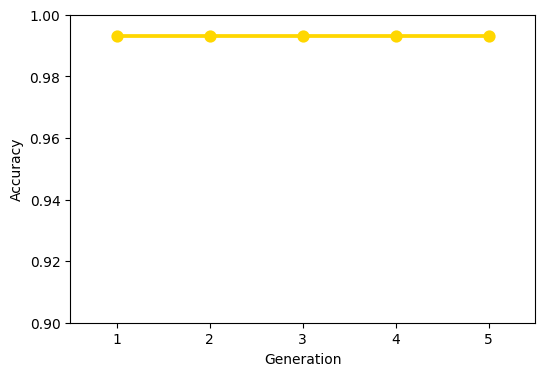

In [44]:
# Visualization
plot(score_bc, 0.9, 1.0, c="gold")

In [45]:
# Get the best chromosome from the last generation
best_chromosome = chromo_df_bc[-1]
selected_features = data_bc.columns[best_chromosome]

In [46]:
# Filter the dataset using the best chromosome
data_bc_filtered = data_bc[selected_features]

In [47]:
# Evaluate classifiers on the filtered dataset
score2 = acc_score(data_bc_filtered, label_bc)
print("Filtered dataset scores:\n", score2)

Filtered dataset scores:
          Classifier  Accuracy
0      RandomForest  0.993007
1          AdaBoost  0.986014
2  GradientBoosting  0.986014
3         LinearSVM  0.979021
4          Logistic  0.979021
5      DecisionTree  0.972028
6         RadialSVM  0.951049
7        KNeighbors  0.951049


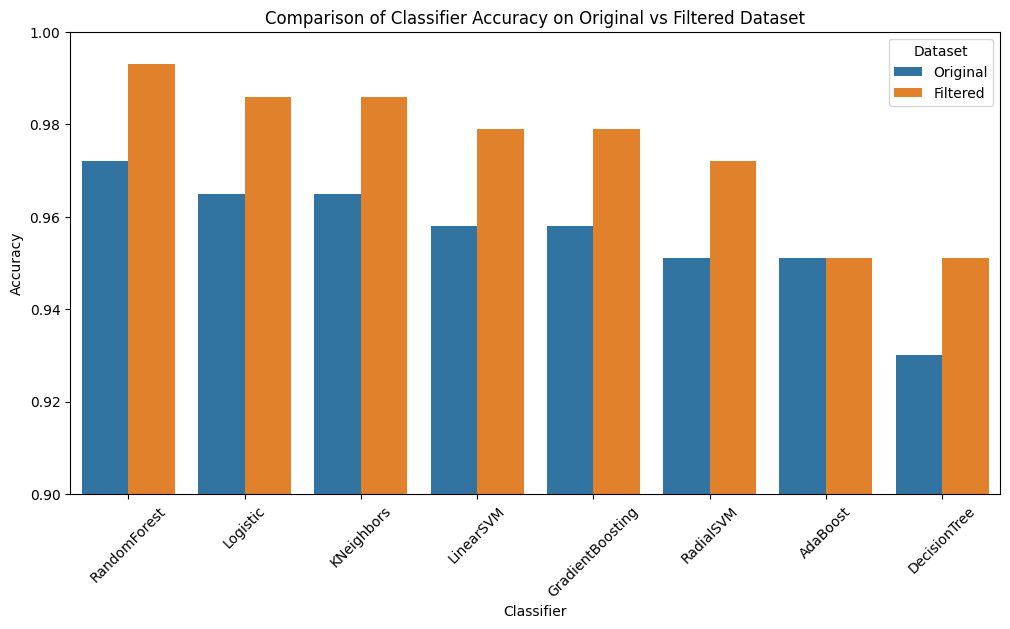

In [48]:
# Visualize the comparison between original and filtered dataset classifier scores
plot_comparison(score1, score2)

# Parkinsson Dataset

In [ ]:
# Load and preprocess the dataset
data_pd = pd.read_csv("ParkinssonDataset.xls")
label_pd = data_pd["status"]
data_pd.drop(["status","name"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

In [ ]:
display(data_pd.head())
print("All the features in this dataset have continuous values")

In [ ]:
score3 = acc_score(data_pd,label_pd)
score3

In [ ]:
# Choose the best classifier and run GA for feature selection
logmodel = RandomForestClassifier(random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pd,label_pd)
chromo_df_pd,score_pd=generations(data_pd,label_pd,size=80,n_feat=data_pd.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

In [ ]:
# Visualization
plot(score_bc, 0.9, 1.0, c="red")

# Dataset 3: PCOS

In [ ]:
data_pcos = pd.read_csv("PCOS.xls")
label_pcos = data_pcos["PCOS (Y/N)"]
data_pcos.drop(["Sl. No","Patient File No.","PCOS (Y/N)","Unnamed: 44","II    beta-HCG(mIU/mL)","AMH(ng/mL)"],axis = 1,inplace = True)
data_pcos["Marraige Status (Yrs)"].fillna(data_pcos['Marraige Status (Yrs)'].describe().loc[['50%']][0], inplace = True) 
data_pcos["Fast food (Y/N)"].fillna(1, inplace = True) 

print("PCOS dataset:\n",data_pcos.shape[0],"Records\n",data_pcos.shape[1],"Features")

In [ ]:
display(data_pcos.head())
print("The features in this dataset have both discrete and continuous values")

In [ ]:
score4 = acc_score(data_pcos,label_pcos)
score4

In [ ]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train,X_test, Y_train, Y_test = split(data_pcos,label_pcos)
chromo_df_pcos,score_pcos=generations(data_pcos,label_pcos,size=80,n_feat=data_pcos.shape[1],n_parents=64,mutation_rate=0.20,n_gen=5,
                         X_train = X_train,X_test = X_test,Y_train = Y_train,Y_test = Y_test)

In [ ]:
plot(score_pcos,0.9,1.0,c = "limegreen")